# LeNET-5 for MNIST

The architecture of a LeNET-5 is given in the image below.

<img src = "http://d2l.ai/_images/lenet.svg">

<b>Layer 1 (C1):</b> The first convolutional layer with 6 kernels of size 5×5 and the stride of 1. Given the input size (32×32×1), the output of this layer is of size 28×28×6.

<b>Layer 2 (S2):</b> A subsampling/pooling layer with 6 kernels of size 2×2 and the stride of 2. The subsampling layer in the original architecture was a bit more complex than the traditionally used max/average pooling layers. I will quote [1]: “ The four inputs to a unit in S2 are added, then multiplied by a trainable coefficient, and added to a trainable bias. The result is passed through a sigmoidal function.”. As a result of non-overlapping receptive fields, the input to this layer is halved in size (14×14×6).

<b>Layer 3 (C3):</b> The second convolutional layer with the same configuration as the first one, however, this time with 16 filters. The output of this layer is 10×10×16.

<b>Layer 4 (S4):</b> The second pooling layer. The logic is identical to the previous one, but this time the layer has 16 filters. The output of this layer is of size 5×5×16.

<b>Layer 5 (C5):</b> The last convolutional layer with 120 5×5 kernels. Given that the input to this layer is of size 5×5×16 and the kernels are of size 5×5, the output is 1×1×120. As a result, layers S4 and C5 are fully-connected. That is also why in some implementations of LeNet-5 actually use a fully-connected layer instead of the convolutional one as the 5th layer. The reason for keeping this layer as a convolutional one is the fact that if the input to the network is larger than the one used in [1] (the initial input, so 32×32 in this case), this layer will not be a fully-connected one, as the output of each kernel will not be 1×1.

<b>Layer 6 (F6):</b> The first fully-connected layer, which takes the input of 120 units and returns 84 units. In the original paper, the authors used a custom activation function — a variant of the tanh activation function. For a thorough explanation, please refer to Appendix A in [1].

<b>Layer 7 (F7):</b> The last dense layer, which outputs 10 units. In [1], the authors used Euclidean Radial Basis Function neurons as activation functions for this layer.

Import the ibraries

In [249]:
import torch
import matplotlib.pyplot as plt
from matplotlib import interactive
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import os
import shutil
import numpy as np

import torchvision.transforms as transforms
import torchvision.datasets

import torch.nn as nn

In [2]:
device = torch.device('cuda:0')
torch.cuda.get_device_name()

'GeForce GTX 1070'

Moving the notebook to GPU. We see that it is already running on GPU. Device being used is GTX 1070. When we create a model object, we still have to send it to GPU though.

In [3]:
torch.cuda.get_device_name(device)

'GeForce GTX 1070'

In [4]:
torch.cuda.is_available()

True

### Data reading 

Data is already downloaded and present in the same directory as this Notebook

with open('t10k-images-idx3-ubyte','r') as file:
    train_images = file.read()


It is cumbersome to read MNIST data as it is encoded in a weird obsolete format. Instead, I will import the data from torchvision database. Focussing on important things here.

In [5]:
image_size = 28
resize = transforms.Resize((image_size,image_size))
tf = transforms.Compose([resize, transforms.ToTensor()])

In [6]:
train_data = torchvision.datasets.MNIST(root=os.getcwd(), train = True,transform = tf, download = True)
val_data = torchvision.datasets.MNIST(os.getcwd(), train = False, transform = tf, download = True)

Dataset has been imported. Now we create a Dataset object and a DataLoader object.

###  Creating LeNET-5 Model custom module

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2) 
        nn.init.kaiming_uniform_(self.cnn1.weight,nonlinearity ='relu')
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        nn.init.kaiming_uniform_(self.cnn2.weight,nonlinearity ='relu')
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.cnn3 = nn.Conv2d(in_channels=16, out_channels= 120, kernel_size=5, padding=0)
        nn.init.kaiming_uniform_(self.cnn3.weight,nonlinearity ='relu')
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)
    def forward(self,x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.avgpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.avgpool2(x)
        x = self.cnn3(x)
        x = torch.relu(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

The model class is ready.He method is used to initialize parameters for Convolution layers. Now we need to create optmizer,model and criterion objects and define the hyperparameters.

In [8]:
learning_rate = 0.1
model = CNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loss= []
validation_loss=[]

###  Training Function for our model

In [9]:
from tqdm.notebook import tqdm

In [10]:
def train_model(model,criterion,optimizer,train_loader,validation_loader,epochs):
    '''
    Function for training the Neural Network.
    '''
    TRAIN_EPOCH_LOSS = []
    TEST_EPOCH_LOSS = []
    TEST_ACCURACY = []
    
    for epoch in range(epochs):
        LOSS = 0
        # Training the model over the training data
        model.train()      #Setting the model to training mode. It essentially sets required_grad to True.
        print("EPOCH: ",epoch)
        print("\tTraining-")
        for x,y in tqdm(train_loader):
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat,y)
            loss.backward();
            optimizer.step()
            LOSS += loss.data
        TRAIN_EPOCH_LOSS.append(LOSS)
        print("\tValidating-")
        # Evaluating the model's performance over validation data. This will be performed every epoch.
        model.eval()
        correct=0
        with torch.no_grad():
            for x,y in tqdm(validation_loader):
                x,y = x.to(device), y.to(device)
                yhat = model(x)
                _,yhat = torch.max(yhat.data,dim=1)
                correct += (yhat == y).sum().item()
        accuracy = correct/100
        print("Test set accuracy for epoch ",epoch," = ",accuracy)
        TEST_ACCURACY.append(accuracy)
        DATA = {'train_epoch_loss':TRAIN_EPOCH_LOSS, 'test_epoch_loss':TEST_EPOCH_LOSS,'accuracy':TEST_ACCURACY}
    return model, optimizer, DATA

### Plotting a Datapoint

In [11]:
def plot_data(data_sample):
    fig = plt.figure()
    fig = plt.imshow(data_sample[0].numpy().reshape(image_size,image_size),cmap='gray')
    plt.title('y = '+str(data_sample[1]))
    plt.show()
    

In [ ]:
for i in range(5):
    plot_data(train_data[i+200])
    

### Calling Function

In [13]:
BATCH_SIZE = 30
EPOCHS = 15
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE)
validation_loader = DataLoader(val_data, batch_size = BATCH_SIZE)

In [14]:
Model, Optimizer, Data = train_model(model,criterion,optimizer,train_loader,validation_loader,EPOCHS) 

EPOCH:  0
	Training-



	Validating-



Test set accuracy for epoch  0  =  96.91
EPOCH:  1
	Training-



	Validating-



Test set accuracy for epoch  1  =  97.77
EPOCH:  2
	Training-



	Validating-



Test set accuracy for epoch  2  =  98.29
EPOCH:  3
	Training-



	Validating-



Test set accuracy for epoch  3  =  98.46
EPOCH:  4
	Training-



	Validating-



Test set accuracy for epoch  4  =  98.53
EPOCH:  5
	Training-



	Validating-



Test set accuracy for epoch  5  =  98.48
EPOCH:  6
	Training-



	Validating-



Test set accuracy for epoch  6  =  98.38
EPOCH:  7
	Training-



	Validating-



Test set accuracy for epoch  7  =  98.6
EPOCH:  8
	Training-



	Validating-



Test set accuracy for epoch  8  =  98.84
EPOCH:  9
	Training-



	Validating-



Test set accuracy for epoch  9  =  98.66
EPOCH:  10
	Training-



	Validating-



Test set accuracy for epoch  10  =  98.7
EPOCH:  11
	Training-



	Validating-



Test set accuracy for epoch  11  =  98.82
EPOCH:  12
	Training-



	Validating-



Test set accuracy for epoch  12  =  98.49
EPOCH:  13
	Training-



	Validating-



Test set accuracy for epoch  13  =  98.84
EPOCH:  14
	Training-



	Validating-



Test set accuracy for epoch  14  =  98.69


In [78]:
Y = torch.tensor(Data["train_epoch_loss"])
X = np.linspace(1,len(Y),len(Y))

### Plotting the Loss over Epoch

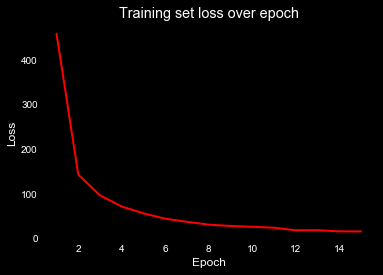

In [91]:
plt.style.use('dark_background')
plt.grid()
plt.plot(X,Y,color='r')
plt.title("Training set loss over epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("Loss_over_epoch.png")

### Saving our Trained Model

The learned parameters are stored is model.state_dict. It is only necessary to save this state dict for the model and the optmizer. This method of storing gives flexibility to restore the model in any other directory or any other system.

In [113]:
PATH = os.getcwd()
filename = './trained_model'
torch.save(model.state_dict(),os.path.join(PATH,filename))

### Now lets watch the Model perform

We will randomly pick some digit data and see what the model predicts. The confidence with with the model predicts a label is simply the value for that label when the output layer is softmaxed.

In [317]:
import random
ROWS = 5
COLS = 15
w = 20
h = 10
ind = random.sample(range(0,len(val_data)),ROWS*COLS)

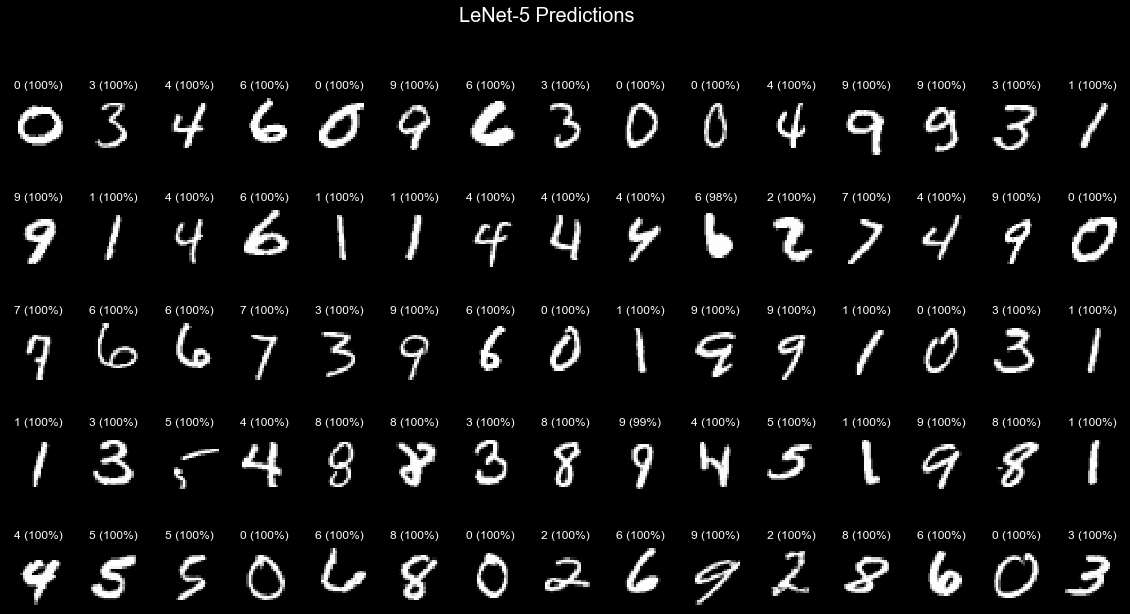

<Figure size 432x288 with 0 Axes>

In [318]:

fig = plt.figure(figsize = (w,h))
for index in range(0,ROWS*COLS):
    plt.subplot(ROWS,COLS,index+1)
    plt.axis('off')
    plt.imshow(val_data[ind[index]][0].squeeze(), cmap = "gray")
    with torch.no_grad():
        model.eval()
        x = val_data[ind[index]][0].to(device)
        x = x.unsqueeze(0)
        x = model(x).data
        x = torch.nn.functional.softmax(x,1)
        prob,label = torch.max(x,1)
        prob = round(prob.item()*100)
    title = str(label.item())+" ("+str(prob)+"%)"
    plt.title(title,fontsize = 12)
plt.suptitle("LeNet-5 Predictions",fontsize = 20)
plt.show()
plt.savefig('Predictions.png')

In [286]:
x = torch.randn(1,1,28,28).to(device)

In [241]:
x = model(x).data
x

tensor([[-5.5528, -2.0982, -1.2199, 14.9190, -9.5727, 10.2264, -5.7308,  2.8421,
         -0.6164, -3.9061]], device='cuda:0')

In [242]:
x = torch.nn.functional.softmax(x,1)
x

tensor([[1.2742e-09, 4.0323e-08, 9.7051e-08, 9.9091e-01, 2.2877e-11, 9.0795e-03,
         1.0665e-09, 5.6377e-06, 1.7745e-07, 6.6130e-09]], device='cuda:0')

In [243]:
prob,maxInd = torch.max(x,1)
prob = round(prob.item()*100)

In [244]:
prob

99

In [245]:
str(prob)

'99'